In [1]:
# Pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn import datasets
from mlxtend.plotting import plot_decision_regions
import math
import seaborn as sns
import timeit


np.random.seed(42)
plt.rcParams['figure.figsize'] = [16, 12]
sns.set_context("notebook", font_scale=1.5)

# Dúvidas 

### **Gini impurity vs Gini Coefficient**

"Gini Coefficient" é muito usado em economia, mede a desigualdade de uma variável numérica, como por exemplo a renda, que podemos tratar como um problema de regressão - obtendo a "média de cada grupo".

"Gini impurity" é normalmente utilizado para definir partições nas árvores de decisão e mede a impureza de uma variável categórica, como cor, ou pergunta binária, que é um problema de classificação - obtendo a "maioria de cada grupo".


Referências:

https://datascience.stackexchange.com/questions/1095/gini-coefficient-vs-gini-impurity-decision-trees 

LIGHT, Richard J.; MARGOLIN, Barry H. An analysis of variance for categorical data. Journal of the American Statistical Association, v. 66, n. 335, p. 534-544, 1971.

## Formulas Latex

https://latex.codecogs.com/eqneditor/editor.php

### **Gini vs Entropia**

A medida de impureza Gini é calculada da seguinte forma:


\begin{equation}
Gini = 1 - \sum_{j} p_j^2
\end{equation}

\begin{equation}
Gini_{min} = 1 - (1^2 + 0^2) = 0
\end{equation}

\begin{equation}
Gini_{max} = 1 - (0.5^2 + 0.5^2) = 1 - (0.25 + 0.25) = 0.5
\end{equation}



A medida de entropia é calculada da seguinte forma:

\begin{equation}
Entropia = -\sum_{j} p_j * log_2(p_j)
\end{equation}

\begin{equation}
Entropia_{min} = -1 * log_2(1) - 0 * log_2(0) = 0
\end{equation}

\begin{equation}
Entropia_{max} = -0.5 * log_2(0.5) - 0.5 * log_2(0.5) = 1
\end{equation}


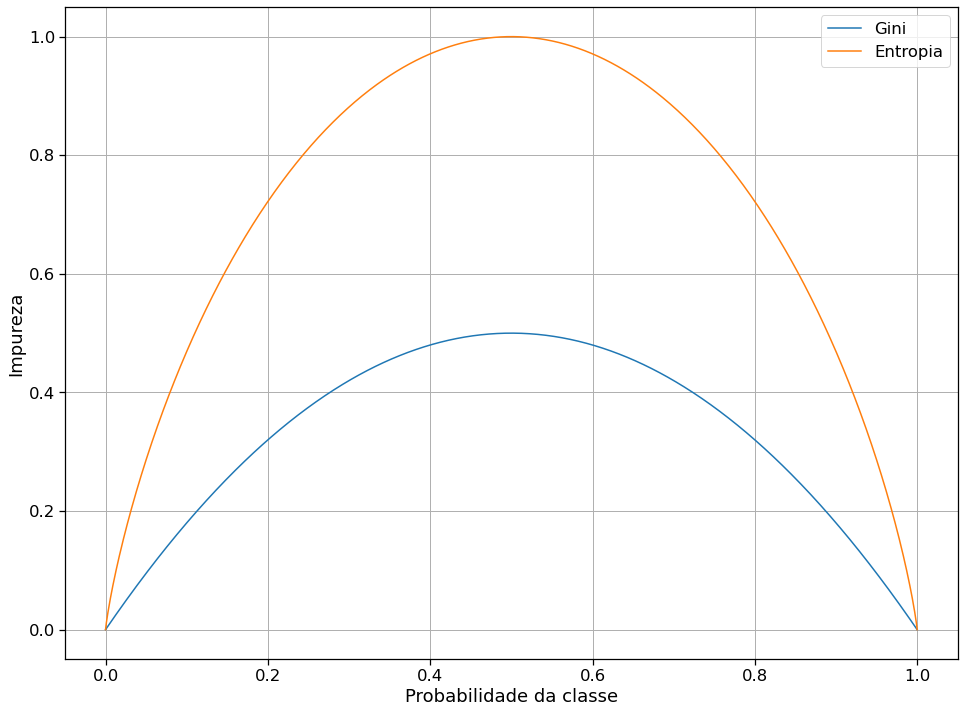

In [3]:
def gini(p):
    g = 1 - (p**2 + (1-p)**2)
    return g

def entropia(p):
    try:
        e = -p*math.log(p,2)-(1-p)*math.log((1-p),2)
        return e
    except:
        e = 0
        return e
    
p = np.linspace(0, 1, 1000)
entropia_p = list(map(entropia,p))
gini_p = list(map(gini,p))


plt.figure()
plt.plot(p,gini_p)
plt.plot(p,entropia_p)
plt.legend(["Gini","Entropia"])
plt.grid(True)
plt.xlabel("Probabilidade da classe")
plt.ylabel("Impureza")
plt.show()


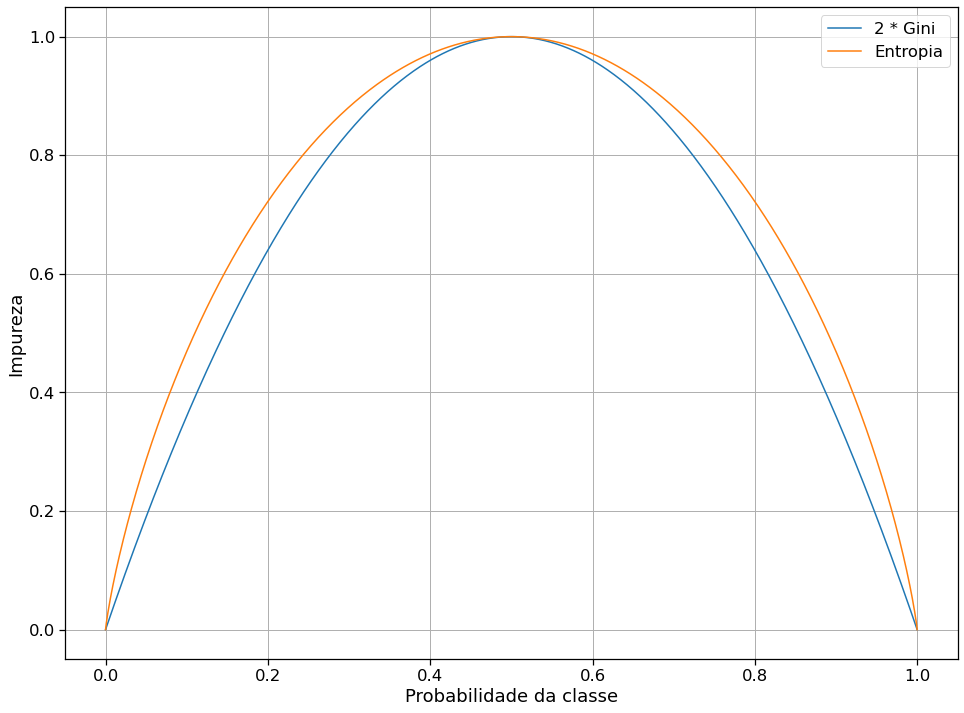

In [4]:
plt.figure()
plt.plot(p,[x * 2 for x in gini_p])
plt.plot(p,entropia_p)
plt.legend(["2 * Gini","Entropia"])
plt.grid(True)
plt.xlabel("Probabilidade da classe")
plt.ylabel("Impureza")
plt.show()

In [5]:
%timeit -r 50 -n 1 map(gini,p)

The slowest run took 11.00 times longer than the fastest. This could mean that an intermediate result is being cached.
280 ns ± 279 ns per loop (mean ± std. dev. of 50 runs, 1 loop each)


In [6]:
%timeit -r 50 -n 1 map(entropia,p)

The slowest run took 7.50 times longer than the fastest. This could mean that an intermediate result is being cached.
272 ns ± 182 ns per loop (mean ± std. dev. of 50 runs, 1 loop each)


Referência: 

https://quantdare.com/decision-trees-gini-vs-entropy/

MARSLAND, Stephen. Machine learning: an algorithmic perspective. CRC press, 2015.

### **Entropia maior que 1?**

O que significa a entropia maior que 1 que vemos nos nós das árvores? O valor máximo da entropia irá depender do número de classes.

In [7]:
-(1/2)*math.log((1/2), 2)-(1/2)*math.log((1/2), 2)

1.0

In [9]:
-(1/3)*math.log((1/3), 2)-(1/3)*math.log((1/3), 2)-(1/3)*math.log((1/3), 2)

1.584962500721156

In [10]:
-(1/4)*math.log((1/4), 2)-(1/4)*math.log((1/4), 2)-(1/4)*math.log((1/4), 2)-(1/4)*math.log((1/4), 2)

2.0

# Exercícios de fixação

### 2 - Considerando a base de dados Vehicle, calcule as métricas de avaliação vistas nessa aula para os classificadores árvores de decisão e florestas aleatórias.

In [11]:
# Carrega o conjunto de dados
vehicle_df = pd.read_csv("data/Vehicle.csv", header=(0))

# Verifica as primeiras linhas
vehicle_df.head()

,Comp,Circ,D.Circ,Rad.Ra,Pr.Axis.Ra,Max.L.Ra,Scat.Ra,Elong,Pr.Axis.Rect,Max.L.Rect,Sc.Var.Maxis,Sc.Var.maxis,Ra.Gyr,Skew.Maxis,Skew.maxis,Kurt.maxis,Kurt.Maxis,Holl.Ra,Class
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus


In [12]:
# Verifica os tipos de dados
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Comp          846 non-null    int64 
 1   Circ          846 non-null    int64 
 2   D.Circ        846 non-null    int64 
 3   Rad.Ra        846 non-null    int64 
 4   Pr.Axis.Ra    846 non-null    int64 
 5   Max.L.Ra      846 non-null    int64 
 6   Scat.Ra       846 non-null    int64 
 7   Elong         846 non-null    int64 
 8   Pr.Axis.Rect  846 non-null    int64 
 9   Max.L.Rect    846 non-null    int64 
 10  Sc.Var.Maxis  846 non-null    int64 
 11  Sc.Var.maxis  846 non-null    int64 
 12  Ra.Gyr        846 non-null    int64 
 13  Skew.Maxis    846 non-null    int64 
 14  Skew.maxis    846 non-null    int64 
 15  Kurt.maxis    846 non-null    int64 
 16  Kurt.Maxis    846 non-null    int64 
 17  Holl.Ra       846 non-null    int64 
 18  Class         846 non-null    object
dtypes: int64

<AxesSubplot:>

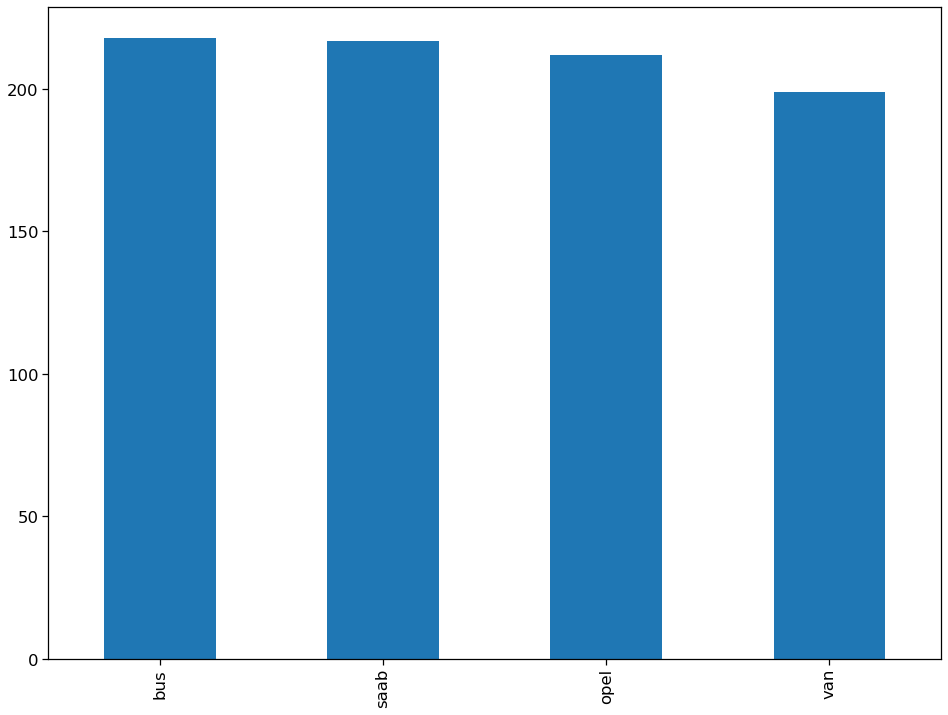

In [13]:
vehicle_df["Class"].value_counts().plot.bar()

In [14]:
# Particiona o conjunto de dados
X_ve = vehicle_df.drop(["Class"], axis = 1).values
y_ve = vehicle_df["Class"].values

p = 0.2 # fracao de elementos no conjunto de teste
x_train, x_test, y_train, y_test = train_test_split(X_ve, y_ve, test_size = p, random_state = 2)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(676, 18)
(676,)
(170, 18)
(170,)


In [25]:
# Instancia os modelos Árvore de Decisão (dt) e Random Forest (rf)
model_dt = DecisionTreeClassifier()
model_rf = RandomForestClassifier()

# Ajusta os modelos ao conjunto de treinamento
model_dt.fit(x_train, y_train)
model_rf.fit(x_train, y_train)

# Realiza as predições
y_pred_dt = model_dt.predict(x_test)
y_pred_rf = model_rf.predict(x_test)

In [26]:
# Análise superficial de desempenho Árvore de Decisão
print("Precisão: ")
print(precision_score(y_test, y_pred_dt, average = 'macro'))
print("Recall/Revocação/Sensibilidade: ")
print(recall_score(y_test, y_pred_dt, average = 'macro'))
print("Relatório de classificação: ")
print(classification_report(y_test, y_pred_dt))
print("Acurácia")
print(accuracy_score(y_test, y_pred_dt))
print("Medida F1")
print(f1_score(y_test, y_pred_dt, average = 'macro'))
print("Matriz de confusão")
print(confusion_matrix(y_test, y_pred_dt))

Precisão: 
0.6589867929153643
Recall/Revocação/Sensibilidade: 
0.6597170686456401
Relatório de classificação: 
              precision    recall  f1-score   support

         bus       0.92      0.90      0.91        49
        opel       0.43      0.40      0.42        40
        saab       0.39      0.42      0.41        33
         van       0.90      0.92      0.91        48

    accuracy                           0.69       170
   macro avg       0.66      0.66      0.66       170
weighted avg       0.69      0.69      0.69       170

Acurácia
0.6941176470588235
Medida F1
0.6589536266811031
Matriz de confusão
[[44  2  3  0]
 [ 2 16 19  3]
 [ 1 16 14  2]
 [ 1  3  0 44]]


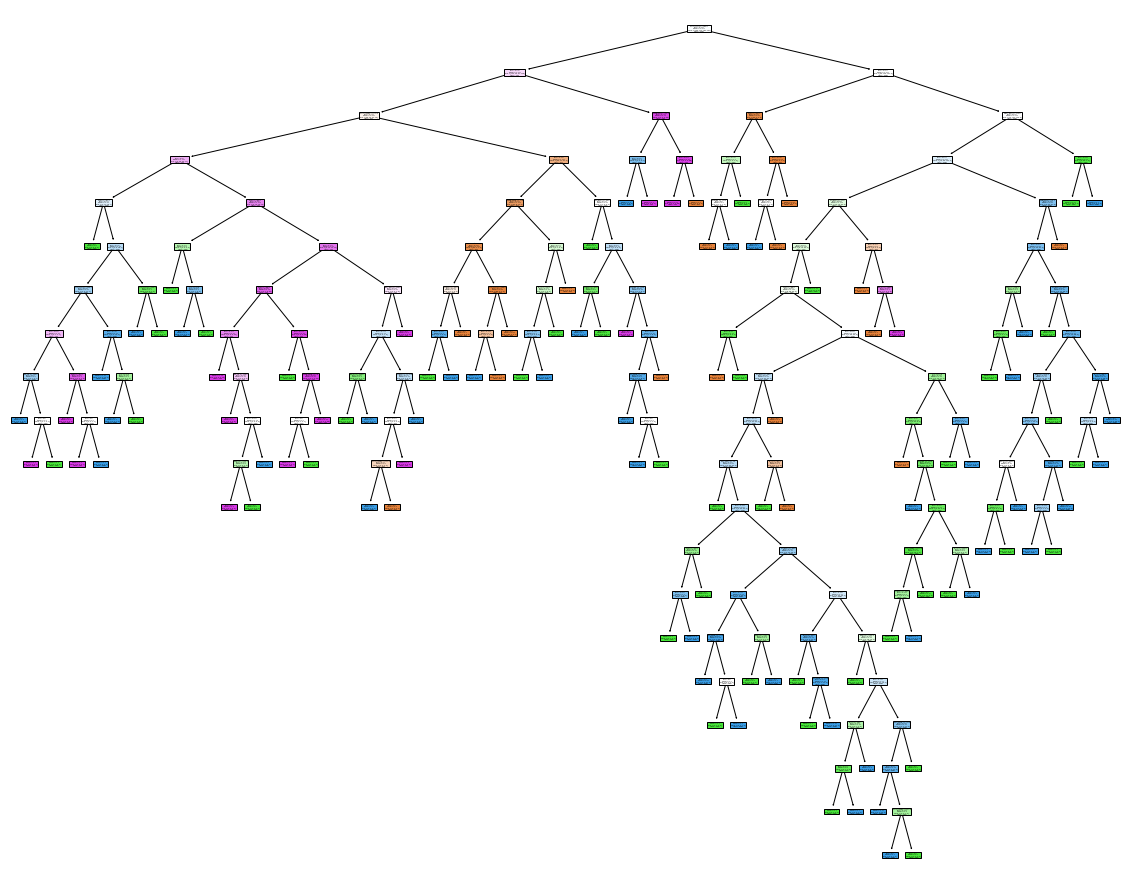

In [27]:
plt.figure(figsize=(20,16))
plot_tree(model_dt,filled=True, feature_names=vehicle_df.drop(["Class"], axis = 1).columns.values, class_names=model_dt.classes_)
plt.show(True)

In [28]:
df_1 = pd.DataFrame({'feature': vehicle_df.drop(["Class"], axis = 1).columns.values, 'importance': model_dt.feature_importances_})
df_1.sort_values(by=['importance'], ascending = False)

,feature,importance
5,Max.L.Ra,0.185168
10,Sc.Var.Maxis,0.126508
11,Sc.Var.maxis,0.126445
9,Max.L.Rect,0.081583
0,Comp,0.076724
4,Pr.Axis.Ra,0.068441
2,D.Circ,0.066380
3,Rad.Ra,0.059745
13,Skew.Maxis,0.031405
12,Ra.Gyr,0.029898


In [29]:
# Análise superficial de desempenho Random Forest
print("Precisão: ")
print(precision_score(y_test, y_pred_rf, average = 'macro'))
print("Recall/Revocação/Sensibilidade: ")
print(recall_score(y_test, y_pred_rf, average = 'macro'))
print("Relatório de classificação: ")
print(classification_report(y_test, y_pred_rf))
print("Acurácia")
print(accuracy_score(y_test, y_pred_rf))
print("Medida F1")
print(f1_score(y_test, y_pred_rf, average = 'macro'))
print("Matriz de confusão")
print(confusion_matrix(y_test, y_pred_rf))

Precisão: 
0.7112275347804905
Recall/Revocação/Sensibilidade: 
0.7174358379715522
Relatório de classificação: 
              precision    recall  f1-score   support

         bus       0.98      0.98      0.98        49
        opel       0.52      0.38      0.43        40
        saab       0.42      0.52      0.47        33
         van       0.92      1.00      0.96        48

    accuracy                           0.75       170
   macro avg       0.71      0.72      0.71       170
weighted avg       0.75      0.75      0.75       170

Acurácia
0.7529411764705882
Medida F1
0.7100319675219701
Matriz de confusão
[[48  0  1  0]
 [ 0 15 22  3]
 [ 1 14 17  1]
 [ 0  0  0 48]]


In [30]:
df_2 = pd.DataFrame({'feature': vehicle_df.drop(["Class"], axis = 1).columns.values, 'importance': model_rf.feature_importances_})
df_2.sort_values(by=['importance'], ascending = False)

,feature,importance
5,Max.L.Ra,0.104369
11,Sc.Var.maxis,0.088125
9,Max.L.Rect,0.080110
2,D.Circ,0.067811
7,Elong,0.064776
10,Sc.Var.Maxis,0.063418
6,Scat.Ra,0.061948
0,Comp,0.059499
4,Pr.Axis.Ra,0.054712
17,Holl.Ra,0.051292


In [31]:
print("Relatório de classificação (Árvore de Decisão): ")
print(classification_report(y_test, y_pred_dt))
print("Relatório de classificação (Random Forest): ")
print(classification_report(y_test, y_pred_rf))

Relatório de classificação (Árvore de Decisão): 
              precision    recall  f1-score   support

         bus       0.92      0.90      0.91        49
        opel       0.43      0.40      0.42        40
        saab       0.39      0.42      0.41        33
         van       0.90      0.92      0.91        48

    accuracy                           0.69       170
   macro avg       0.66      0.66      0.66       170
weighted avg       0.69      0.69      0.69       170

Relatório de classificação (Random Forest): 
              precision    recall  f1-score   support

         bus       0.98      0.98      0.98        49
        opel       0.52      0.38      0.43        40
        saab       0.42      0.52      0.47        33
         van       0.92      1.00      0.96        48

    accuracy                           0.75       170
   macro avg       0.71      0.72      0.71       170
weighted avg       0.75      0.75      0.75       170



## 3 - Faça a classificação dos dados gerados artificialmente com o código abaixo. Compare os resultados para os métodos vistos nessa aula.

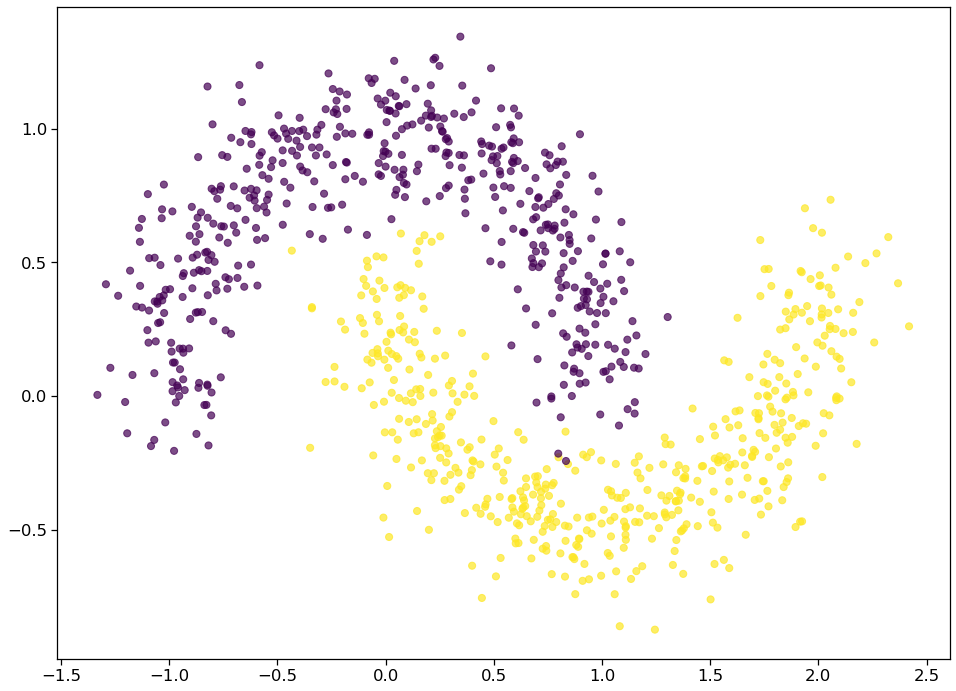

In [42]:
plt.figure()

n_samples = 1000

data  = datasets.make_moons(n_samples=n_samples, noise=.15, random_state=42)
X = data[0]
y = data[1]
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50, alpha=0.7)
plt.show(True)

In [43]:
# Particiona o conjunto de dados
p = 0.2 # fracao de elementos no conjunto de teste
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = p, random_state = 2)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(800, 2)
(800,)
(200, 2)
(200,)


In [44]:
# Instancia os modelos Árvore de Decisão (dt) e Random Forest (rf)
model_dt = DecisionTreeClassifier()
model_rf = RandomForestClassifier()

# Ajusta os modelos ao conjunto de treinamento
model_dt.fit(x_train, y_train)
model_rf.fit(x_train, y_train)

# Realiza as predições
y_pred_dt = model_dt.predict(x_test)
y_pred_rf = model_rf.predict(x_test)

Text(0.5, 1.0, 'Random Forest')

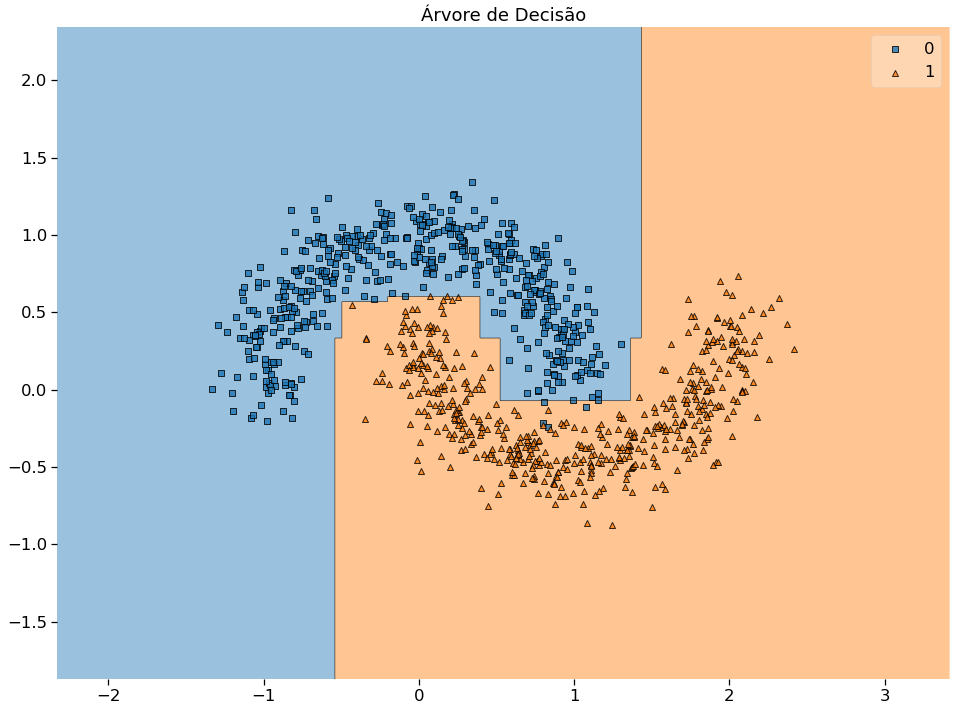

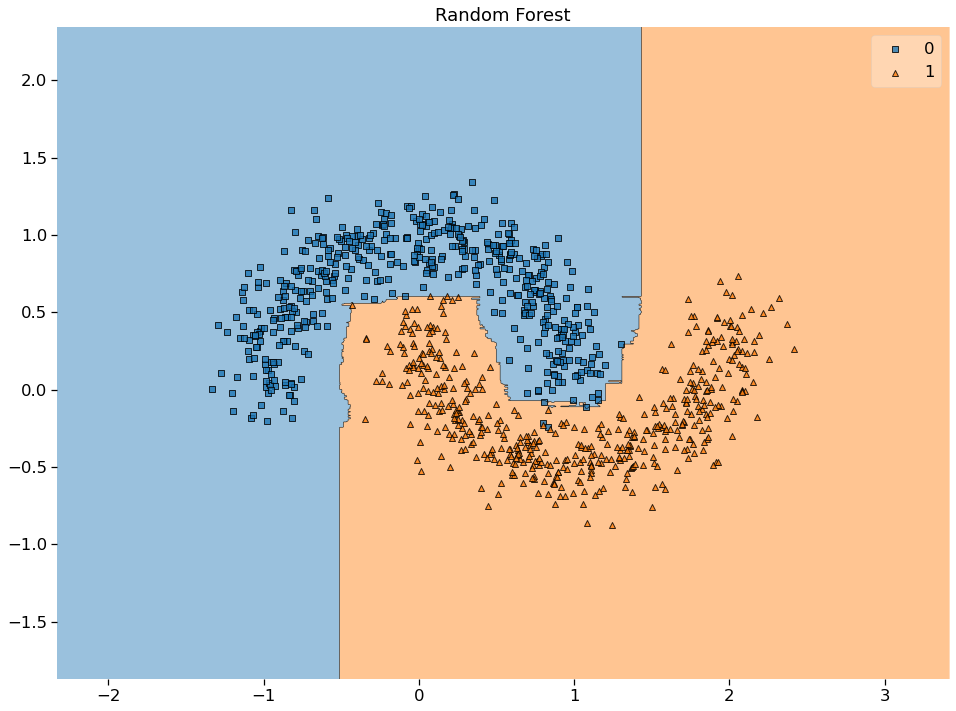

In [45]:
plt.figure(1)
plot_decision_regions(X, y, model_dt)
plt.title('Árvore de Decisão')

plt.figure(2)
plot_decision_regions(X, y, model_rf)
plt.title('Random Forest')

In [46]:
print("Relatório de classificação (Árvore de Decisão): ")
print(classification_report(y_test, y_pred_dt))
print("Relatório de classificação (Random Forest): ")
print(classification_report(y_test, y_pred_rf))

Relatório de classificação (Árvore de Decisão): 
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        95
           1       0.98      0.99      0.99       105

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200

Relatório de classificação (Random Forest): 
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        95
           1       0.98      0.99      0.99       105

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200



## Moisés Santos

email = moises0rocha@gmail.com